# 01 — Data Quality Analysis

**NovaCred Credit Application Governance | DEGO 2606**

**Author:** Jasper Gräfe (Data Engineer)

---

## Objectives

Assess the quality of `raw_credit_applications.json` across four dimensions:

| Dimension | Description |
|-----------|-------------|
| Completeness | Are all required fields present and populated? |
| Consistency | Are values formatted and coded uniformly? |
| Validity | Do values conform to expected ranges and formats? |
| Accuracy | Are values plausible and internally consistent? |

---

## Sections

0. Setup & Data Loading
1. Dataset Overview & Schema Profiling
2. Completeness Analysis
3. Consistency Analysis
4. Validity Analysis
5. Accuracy Analysis
6. Consolidated Quality Report & Clean Export
7. Quality Scores & Governance Notes

---
## Section 0 — Setup & Data Loading

In [1]:
import json
import re
import pathlib
import collections
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = pathlib.Path('../data/raw_credit_applications.json')

with open(DATA_PATH, 'r') as f:
    raw_data = json.load(f)

print(f'Records loaded: {len(raw_data)}')
print(f'\nSample record keys: {list(raw_data[0].keys())}')

Records loaded: 502

Sample record keys: ['_id', 'applicant_info', 'financials', 'spending_behavior', 'decision', 'processing_timestamp']


In [3]:
def flatten_record(record):
    flat = {'_id': record.get('_id')}
    flat.update(record.get('applicant_info', {}))
    flat.update(record.get('financials', {}))
    decision = record.get('decision', {})
    flat['loan_approved']    = decision.get('loan_approved')
    flat['interest_rate']    = decision.get('interest_rate')
    flat['approved_amount']  = decision.get('approved_amount')
    flat['rejection_reason'] = decision.get('rejection_reason')
    return flat

df = pd.DataFrame([flatten_record(r) for r in raw_data])
print(f'Shape: {df.shape}')
df.head(3)

Shape: (502, 17)


,_id,full_name,email,ssn,ip_address,gender,date_of_birth,zip_code,annual_income,credit_history_months,debt_to_income,savings_balance,loan_approved,interest_rate,approved_amount,rejection_reason,annual_salary
0,app_200,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000,23,0.20,31212,False,NaN,NaN,algorithm_risk_score,NaN
1,app_037,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,78000,51,0.18,17915,False,NaN,NaN,algorithm_risk_score,NaN
2,app_215,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000,41,0.21,37909,True,3.7,59000.0,None,NaN


---
## Section 1 — Dataset Overview & Schema Profiling

In [4]:
# Basic overview
print(f'Shape: {df.shape}')
print(f'\nColumn dtypes:')
print(df.dtypes)

Shape: (502, 17)

Column dtypes:
_id                       object
full_name                 object
email                     object
ssn                       object
ip_address                object
gender                    object
date_of_birth             object
zip_code                  object
annual_income             object
credit_history_months      int64
debt_to_income           float64
savings_balance            int64
loan_approved               bool
interest_rate            float64
approved_amount          float64
rejection_reason          object
annual_salary            float64
dtype: object


In [5]:
# Discover all top-level keys present across every record
all_top_keys = set()
for record in raw_data:
    all_top_keys.update(record.keys())

expected_top_keys = {'_id', 'applicant_info', 'financials', 'decision', 'spending_behavior'}
extra_keys = all_top_keys - expected_top_keys

print(f'Top-level keys found:  {sorted(all_top_keys)}')
print(f'Extra (not in schema): {sorted(extra_keys)}')

Top-level keys found:  ['_id', 'applicant_info', 'decision', 'financials', 'loan_purpose', 'notes', 'processing_timestamp', 'spending_behavior']
Extra (not in schema): ['loan_purpose', 'notes', 'processing_timestamp']


In [6]:
# Add any discovered extra fields to the DataFrame
for key in sorted(extra_keys):
    df[key] = [r.get(key) for r in raw_data]

print(f'Updated shape: {df.shape}')
df.head(3)

Updated shape: (502, 20)


,_id,full_name,email,ssn,ip_address,gender,date_of_birth,zip_code,annual_income,credit_history_months,debt_to_income,savings_balance,loan_approved,interest_rate,approved_amount,rejection_reason,annual_salary,loan_purpose,notes,processing_timestamp
0,app_200,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000,23,0.20,31212,False,NaN,NaN,algorithm_risk_score,NaN,None,None,2024-01-15T00:00:00Z
1,app_037,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,78000,51,0.18,17915,False,NaN,NaN,algorithm_risk_score,NaN,None,None,None
2,app_215,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000,41,0.21,37909,True,3.7,59000.0,None,NaN,vacation,None,None


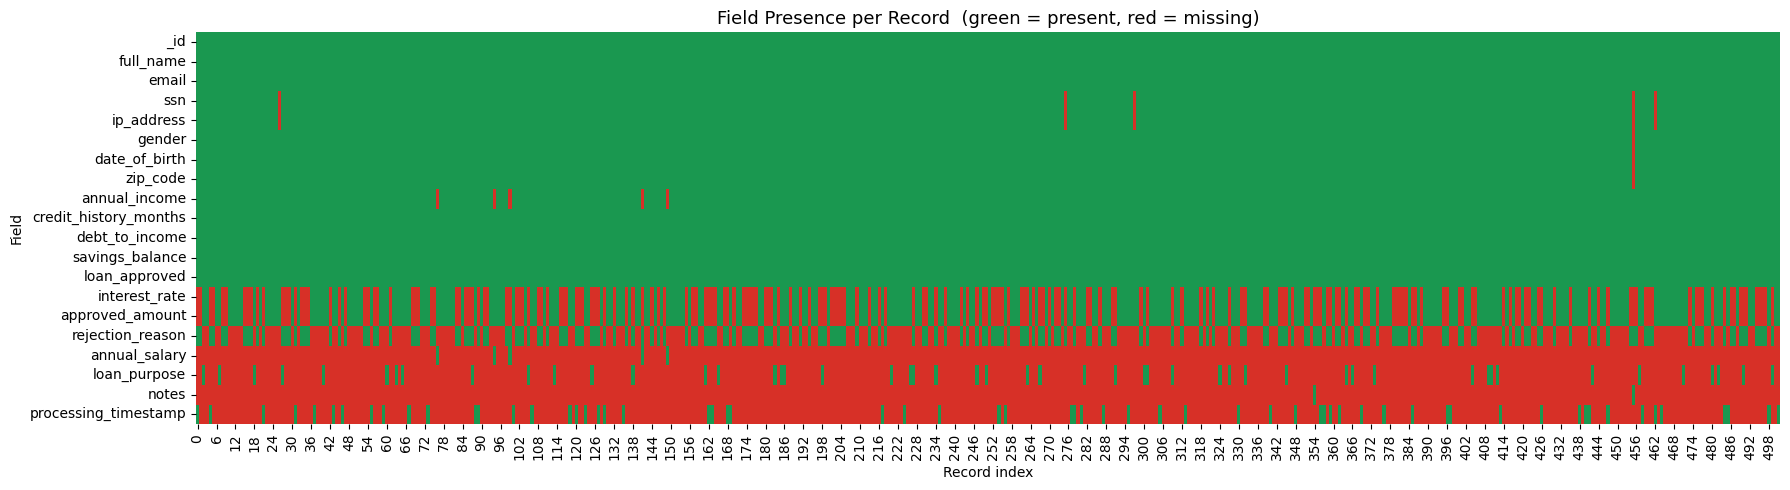

In [7]:
# Field presence heatmap — green = present, red = missing
presence = df.notna().astype(int)

fig, ax = plt.subplots(figsize=(18, 5))
sns.heatmap(
    presence.T,
    cmap=['#d73027', '#1a9850'],
    cbar=False,
    ax=ax,
    linewidths=0
)
ax.set_title('Field Presence per Record  (green = present, red = missing)', fontsize=13)
ax.set_xlabel('Record index')
ax.set_ylabel('Field')
plt.tight_layout()
plt.savefig('../reports/dq_field_presence_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Per-field completeness table
completeness = pd.DataFrame({
    'present': df.notna().sum(),
    'missing': df.isna().sum(),
    'pct_present': (df.notna().sum() / len(df) * 100).round(1)
}).sort_values('pct_present')

print(f'Total records: {len(df)}')
print()
print(completeness.to_string())

Total records: 502

                       present  missing  pct_present
notes                        2      500          0.4
annual_salary                5      497          1.0
loan_purpose                50      452         10.0
processing_timestamp        62      440         12.4
rejection_reason           210      292         41.8
approved_amount            292      210         58.2
interest_rate              292      210         58.2
ssn                        497        5         99.0
ip_address                 497        5         99.0
annual_income              497        5         99.0
gender                     501        1         99.8
date_of_birth              501        1         99.8
zip_code                   501        1         99.8
_id                        502        0        100.0
savings_balance            502        0        100.0
debt_to_income             502        0        100.0
email                      502        0        100.0
full_name                 

---
## Section 2 — Completeness Analysis

In [9]:
# To be implemented

---
## Section 3 — Consistency Analysis

In [10]:
# To be implemented

---
## Section 4 — Validity Analysis

In [11]:
# To be implemented

---
## Section 5 — Accuracy Analysis

In [12]:
# To be implemented

---
## Section 6 — Consolidated Quality Report & Clean Export

In [13]:
# To be implemented

---
## Section 7 — Quality Scores & Governance Notes

In [14]:
# To be implemented